In [15]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import os
from time import time, sleep
import ctypes
import sys
import skimage.io as skio
from scipy.signal import find_peaks
import skimage.exposure
from skimage.filters.rank import entropy
from skimage.measure import shannon_entropy
from scipy.signal import medfilt
from skimage.morphology import disk
import glob
import xgboost as xgb
from tifffile import imread, imwrite
import cv2
from joblib import Parallel, delayed
import seaborn as sns
from towbintools.foundation.image_handling import normalize_image
from towbintools.foundation.image_quality import normalized_variance_measure
from towbintools.foundation.file_handling import get_dir_filemap
from towbintools.foundation.zstack import normalize_zstack
from towbintools.foundation.utils import nan_helper

from statannotations.Annotator import Annotator

In [16]:
def extract_features(img, features_size):
    img = normalize_image(img)
    std = np.std(img, axis =0)
    feature = np.zeros((1,features_size))
    feature[0, 0:std.shape[0]] = std
    return feature

def count_orientation_errors(orientation):
    # errors = np.count_nonzero(np.array(orientation) == [0, 0, 1])
    errors = 0
    for orient in orientation:
        if orient == [0, 0, 1]:
            errors += 1
    return errors

def extractPump_norm(straightened_image, clf):
    feature = extract_features(straightened_image, 5000)
    orientation_prediction = clf.predict_proba(feature).squeeze()
    # convert proba to one hot encoding
    pred_class = np.argmax(orientation_prediction)
    orientation = [0, 0, 0]
    orientation[pred_class] = 1
    
    std = np.std(straightened_image, axis =0)

    peaks, peak_dict = find_peaks(std, distance=20, prominence = 0.05, height = 0.1)


    if orientation == [1, 0, 0]:
        # plt.plot(straightIm[:, peaks[-1]])
        # plt.show()
        try:
            return -peak_dict['peak_heights'][-1], orientation
        except IndexError:
            return np.nan, orientation
    elif orientation == [0, 1, 0]:
        try:
            return -peak_dict['peak_heights'][0], orientation
        except IndexError:
            return np.nan, orientation
    else:
        return np.nan, orientation
    
    
def analyse_video(vid, model, **kwargs):
    min_std = kwargs.get('min_std', 0.008)
    std_coeff = kwargs.get('std_coeff', 0.75)
    distance = kwargs.get('distance', 4)
    wlen = kwargs.get('wlen', 10)

    print(f'min std: {min_std}')

    try:
        pump = []
        orientation = []

        clf = xgb.XGBClassifier()
        clf.load_model(model)
        
        for i in range(vid.shape[0]):
            pump_value, orient = extractPump_norm(vid[i, :, :], clf)
            pump.append(pump_value)
            orientation.append(orient)

        orientation_errors = count_orientation_errors(orientation)

        if orientation_errors/len(orientation) > 0.10:
            return np.nan

        pump = np.array(pump)

        pump = medfilt(pump)

        plt.plot(pump)
        nans, x= nan_helper(pump)
        pump[nans]= np.interp(x(nans), x(~nans), pump[~nans])

        pump = medfilt(pump)
        
        std = np.std(pump)
        std = max(std, min_std)
        peaks, _ = find_peaks(pump, distance=distance, prominence=std_coeff*std, wlen=wlen)

        # plt.plot(pump)
        # plt.plot(peaks, pump[peaks], "x")
        # plt.show()

        return len(peaks)
    except ValueError:
        return np.nan

def process_video(video_path, **kwargs):
    video_path = video_path.replace('/mnt', '//izbkingston')
    if video_path:
        vid = imread(video_path)
        mean_normalized_variance_of_vid = np.mean([normalized_variance_measure(frame) for frame in vid])
        if mean_normalized_variance_of_vid < 400:
            return np.nan
        normalized_vid = normalize_zstack(vid, each_plane = False, dest_dtype = np.float64) # type: ignore
        return analyse_video(normalized_vid, model=r"C:\Users\sacha\Documents\towbin_lab\pharynx\classify_orientation\model.json", **kwargs)
    else:
        return np.nan

In [17]:
import contextlib
from tqdm import tqdm
import joblib

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [18]:
video_dir = r"//izbkingston/external.data/TowbinLab/kstojanovski/20220401_Ti2_20x_160-182-190_pumping_25C_20220401_173300_429/analysis/str_pharynx_videos/"
video_filemap = get_dir_filemap(video_dir)

# video_dir = r"//izbkingston/external.data/TowbinLab/kstojanovski/20220629_Ti2_20x_160-182-190_pumping_25C_20220629_154238_325/analysis/str_pharynx_videos/"
# video_filemap = get_dir_filemap(video_dir)

video_filemap.reset_index(drop=True, inplace=True)
video_filemap.rename(columns={'ImagePath': 'PumpingVideos'}, inplace=True)


# analysis_filemap_path = '/mnt/external.data/TowbinLab/kstojanovski/20220401_Ti2_20x_160-182-190_pumping_25C_20220401_173300_429/analysis/report/analysis_filemap.csv'

analysis_filemap_path = '//izbkingston/external.data/TowbinLab/kstojanovski/20220401_Ti2_20x_160-182-190_pumping_25C_20220401_173300_429/analysis/report/analysis_filemap.csv'
analysis_filemap = pd.read_csv(analysis_filemap_path)

# analysis_filemap_path = '//izbkingston/external.data/TowbinLab/kstojanovski/20220629_Ti2_20x_160-182-190_pumping_25C_20220629_154238_325/analysis/report/analysis_filemap.csv'
# analysis_filemap = pd.read_csv(analysis_filemap_path)

video_filemap = video_filemap.merge(analysis_filemap, on=['Time', 'Point'], how='left')

with tqdm_joblib(tqdm(desc="Pharynx pump count", total=len(video_filemap['PumpingVideos'].values))) as progress_bar:
    video_filemap['PumpCount'] = Parallel(n_jobs=12, prefer="processes")(delayed(process_video)(video_path, min_std=0.008, std_coeff=0.55, distance=3, wlen=10) for video_path in video_filemap['PumpingVideos'])
video_filemap.to_csv('./pumping_auto_old_experiment.csv', index=False)
# points_of_strains = {'WBT160' : (0, 13), 'WBT182' : (14, 43)}
points_of_strains = {'WBT160' : (0, 20), 'WBT182' : (21, 41), 'WBT190' : (42, 58)}
video_length = 10

# video_filemap = pd.read_csv('./pumping_auto.csv')
# points_to_exclude = [51, 52, 53, 54, 55, 56, 57]
points_to_exclude = [17, 28]
video_filemap['Strain'] = video_filemap['Point'].apply(lambda x: [strain for strain, points in points_of_strains.items() if x in range(points[0], points[1]+1)][0])
video_filemap['PumpRate'] = video_filemap['PumpCount']/video_length

Pharynx pump count: 100%|██████████| 17700/17700 [13:41<00:00, 21.56it/s] 


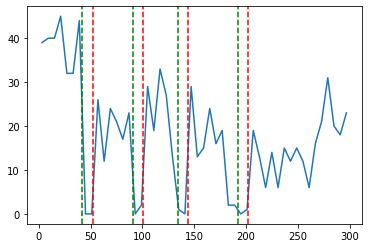

In [19]:
point = 3


data_of_point = video_filemap[video_filemap['Point'] == point].dropna(subset = ['PumpRate'])

m1 = data_of_point['M1'].values[0]
m2 = data_of_point['M2'].values[0]
m3 = data_of_point['M3'].values[0]
m4 = data_of_point['M4'].values[0]

pumping_of_point = data_of_point['PumpCount'].values
time = data_of_point['Time'].values

plt.plot(time, pumping_of_point)

#plot vertical line at m1 

plt.axvline(x=m1, color='r', linestyle='--')
plt.axvline(x=m1-10, color='g', linestyle='--')
plt.axvline(x=m2, color='r', linestyle='--')
plt.axvline(x=m2-10, color='g', linestyle='--')
plt.axvline(x=m3, color='r', linestyle='--')
plt.axvline(x=m3-10, color='g', linestyle='--')
plt.axvline(x=m4, color='r', linestyle='--')
plt.axvline(x=m4-10, color='g', linestyle='--')

plt.show()

In [20]:
mean_dataframe = pd.DataFrame(columns=['Point', 'L2_mean', 'L3_mean', 'L4_mean', 'Strain'])
for point in video_filemap['Point'].unique():
    data_of_point = video_filemap[video_filemap['Point'] == point]
    m1 = data_of_point['M1'].values[0]
    m2 = data_of_point['M2'].values[0]
    m3 = data_of_point['M3'].values[0]
    m4 = data_of_point['M4'].values[0]
    strain = data_of_point['Strain'].values[0]

    pumping_rate_l2 = np.nan
    pumping_rate_l3 = np.nan
    pumping_rate_l4 = np.nan

    if np.isfinite(m1) and np.isfinite(m2):
        time_range = (m1+2, m2-14)
        pumping_rate_l2 = data_of_point[data_of_point['Time'] >= time_range[0]]
        pumping_rate_l2 = pumping_rate_l2[pumping_rate_l2['Time'] <= time_range[1]]['PumpRate']
        pumping_rate_l2 = pumping_rate_l2.mean()
    if np.isfinite(m2) and np.isfinite(m3):
        time_range = (m2+2, m3-14)
        pumping_rate_l3 = data_of_point[data_of_point['Time'] >= time_range[0]]
        pumping_rate_l3 = pumping_rate_l3[pumping_rate_l3['Time'] <= time_range[1]]['PumpRate']
        pumping_rate_l3 = pumping_rate_l3.mean()
    if np.isfinite(m3) and np.isfinite(m4):
        time_range = (m3+2, m4-14)
        pumping_rate_l4 = data_of_point[data_of_point['Time'] >= time_range[0]]
        pumping_rate_l4 = pumping_rate_l4[pumping_rate_l4['Time'] <= time_range[1]]['PumpRate']
        pumping_rate_l4 = pumping_rate_l4.mean()
    
    
    res = {'Point': point, 'L2_mean': pumping_rate_l2, 'L3_mean': pumping_rate_l3, 'L4_mean': pumping_rate_l4, 'Strain': strain}
    df_res = pd.DataFrame([res])
    mean_dataframe = pd.concat([mean_dataframe, df_res], ignore_index=True)

print(mean_dataframe)

   Point   L2_mean   L3_mean   L4_mean  Strain
0      0  2.183333     2.425  1.971429  WBT160
1      1  1.966667      2.36    1.6625  WBT160
2      2      2.02     2.625  1.685714  WBT160
3      3      2.05      2.42  1.685714  WBT160
4      4       3.2      2.86    1.9375  WBT160
5      5  1.785714       2.0    1.6125  WBT160
6      6    2.6125      2.15  2.157143  WBT160
7      7      1.96       2.0    2.1875  WBT160
8      8       NaN       NaN       NaN  WBT160
9      9      2.14      2.72  1.714286  WBT160
10    10       NaN       NaN  1.814286  WBT160
11    11  2.233333       2.6     1.875  WBT160
12    12  1.442857       2.5  1.433333  WBT160
13    13  1.783333      2.16       NaN  WBT160
14    14      2.12     2.825  1.271429  WBT160
15    15       1.5     2.825    1.7125  WBT160
16    16  1.983333       2.2  1.271429  WBT160
17    17       1.8       1.6       1.8  WBT160
18    18  1.383333      2.45  1.914286  WBT160
19    19  1.816667  3.233333  2.157143  WBT160
20    20     

In [23]:
mean_intermolt_dataframe = pd.DataFrame(columns=['Point', 'MeanIntermoltPumping', 'Strain'])

# for point in video_filemap['Point'].unique():
#     data_of_point = video_filemap[video_filemap['Point'] == point]
#     m1 = data_of_point['M1'].values[0]
#     m2 = data_of_point['M2'].values[0]
#     m3 = data_of_point['M3'].values[0]
#     m4 = data_of_point['M4'].values[0]
#     strain = data_of_point['Strain'].values[0]

#     if np.isfinite(m1) and (not point in points_to_exclude):
#         # print(f'm1 = {m1}')
#         moulting_time = np.arange(0, m1).tolist()
#         moulting_time_m1 = np.arange(m1, m1+2)
#         moulting_time.extend(moulting_time_m1)
#         if np.isfinite(m2):
#             # print(f'm2 = {m2}')
#             moulting_time_m2 = np.arange(m2-14, m2+2)
#             moulting_time.extend(moulting_time_m2)
#         if np.isfinite(m3):
#             # print(f'm3 = {m3}')
#             moulting_time_m3 = np.arange(m3-14, m3+2)
#             moulting_time.extend(moulting_time_m3)
#         if np.isfinite(m4):
#             # print(f'm4 = {m4}')
#             moulting_time_m4 = np.arange(m4-14, m4+2)
#             moulting_time.extend(moulting_time_m4)
#         moulting_time = np.array(moulting_time).flatten().astype(int)
        

#         # Get the pumping rate outside of moulting
        
    
#         # print(moulting_time)
#         pumping_of_point = data_of_point[~data_of_point['Time'].isin(moulting_time)]['PumpRate']
#         pumping_of_point = pumping_of_point.dropna()
#         # print(pumping_of_point)

#         mean_intermolt_pumping = pumping_of_point.mean()

#         res = {'Point': point, 'MeanIntermoltPumping': mean_intermolt_pumping.astype(np.float64), 'Strain': strain}
#         df_res = pd.DataFrame([res])
#         mean_intermolt_dataframe = pd.concat([mean_intermolt_dataframe, df_res], ignore_index=True)

for point in video_filemap['Point'].unique():
    data_of_point = video_filemap[video_filemap['Point'] == point]
    m1 = data_of_point['M1'].values[0]
    m2 = data_of_point['M2'].values[0]
    m3 = data_of_point['M3'].values[0]
    m4 = data_of_point['M4'].values[0]
    strain = data_of_point['Strain'].values[0]

    if (not point in points_to_exclude):
        moulting_time = []
        if np.isfinite(m1):
            # print(f'm1 = {m1}')
            moulting_time_m1 = np.arange(m1, m1+2)
            moulting_time.extend(moulting_time_m1)
        if np.isfinite(m2):
            # print(f'm2 = {m2}')
            moulting_time_m2 = np.arange(m2-14, m2+2)
            moulting_time.extend(moulting_time_m2)
        if np.isfinite(m3):
            # print(f'm3 = {m3}')
            moulting_time_m3 = np.arange(m3-14, m3+2)
            moulting_time.extend(moulting_time_m3)
        if np.isfinite(m4):
            # print(f'm4 = {m4}')
            moulting_time_m4 = np.arange(m4-14, m4+2)
            moulting_time.extend(moulting_time_m4)
        moulting_time = np.array(moulting_time).flatten().astype(int)
        

        # Get the pumping rate outside of moulting
        
    
        # print(moulting_time)
        pumping_of_point = data_of_point[~data_of_point['Time'].isin(moulting_time)]['PumpRate']
        pumping_of_point = pumping_of_point.dropna()
        # print(pumping_of_point)

        mean_intermolt_pumping = pumping_of_point.mean()

        res = {'Point': point, 'MeanIntermoltPumping': mean_intermolt_pumping, 'Strain': strain}
        df_res = pd.DataFrame([res])
        mean_intermolt_dataframe = pd.concat([mean_intermolt_dataframe, df_res], ignore_index=True)

In [24]:
mean_molt_dataframe = pd.DataFrame(columns=['Point', 'MeanMoltPumping', 'Strain'])

# for point in video_filemap['Point'].unique():
#     data_of_point = video_filemap[video_filemap['Point'] == point]
#     m1 = data_of_point['M1'].values[0]
#     m2 = data_of_point['M2'].values[0]
#     m3 = data_of_point['M3'].values[0]
#     m4 = data_of_point['M4'].values[0]

#     strain = data_of_point['Strain'].values[0]

#     if np.isfinite(m1) and (not point in points_to_exclude):
#         # print(f'm1 = {m1}')
#         moulting_time = np.arange(m1-10, m1-1).tolist()
#         # moulting_time.extend(moulting_time_m1)
#         if np.isfinite(m2):
#             # print(f'm2 = {m2}')
#             moulting_time_m2 = np.arange(m2-10, m2-1)
#             moulting_time.extend(moulting_time_m2)
#         if np.isfinite(m3):
#             # print(f'm3 = {m3}')
#             moulting_time_m3 = np.arange(m3-10, m3-1)
#             moulting_time.extend(moulting_time_m3)
#         if np.isfinite(m4):
#             # print(f'm4 = {m4}')
#             moulting_time_m4 = np.arange(m4-10, m4-1)
#             moulting_time.extend(moulting_time_m4)
#         moulting_time = np.array(moulting_time).flatten().astype(int)
        

#         # Get the pumping rate outside of moulting
        
    
#         # print(moulting_time)
#         pumping_of_point = data_of_point[data_of_point['Time'].isin(moulting_time)]['PumpRate']
#         pumping_of_point = pumping_of_point.dropna()
#         # print(pumping_of_point)

#         mean_molt_pumping = pumping_of_point.mean()

#         res = {'Point': point, 'MeanMoltPumping': mean_molt_pumping, 'Strain': strain}
#         df_res = pd.DataFrame([res])
#         mean_molt_dataframe = pd.concat([mean_molt_dataframe, df_res], ignore_index=True)

for point in video_filemap['Point'].unique():
    data_of_point = video_filemap[video_filemap['Point'] == point]
    m1 = data_of_point['M1'].values[0]
    m2 = data_of_point['M2'].values[0]
    m3 = data_of_point['M3'].values[0]
    m4 = data_of_point['M4'].values[0]

    strain = data_of_point['Strain'].values[0]

    if (not point in points_to_exclude):
        # print(f'm1 = {m1}')
        moulting_time = []
        if np.isfinite(m1):
            np.arange(m1-10, m1-1).tolist()
            moulting_time.extend(moulting_time_m1)
        # moulting_time.extend(moulting_time_m1)
        if np.isfinite(m2):
            # print(f'm2 = {m2}')
            moulting_time_m2 = np.arange(m2-10, m2-1)
            moulting_time.extend(moulting_time_m2)
        if np.isfinite(m3):
            # print(f'm3 = {m3}')
            moulting_time_m3 = np.arange(m3-10, m3-1)
            moulting_time.extend(moulting_time_m3)
        if np.isfinite(m4):
            # print(f'm4 = {m4}')
            moulting_time_m4 = np.arange(m4-10, m4-1)
            moulting_time.extend(moulting_time_m4)
        moulting_time = np.array(moulting_time).flatten().astype(int)
        

        # Get the pumping rate outside of moulting
        
    
        # print(moulting_time)
        pumping_of_point = data_of_point[data_of_point['Time'].isin(moulting_time)]['PumpRate']
        pumping_of_point = pumping_of_point.dropna()
        # print(pumping_of_point)

        mean_molt_pumping = pumping_of_point.mean()

        res = {'Point': point, 'MeanMoltPumping': mean_molt_pumping, 'Strain': strain}
        df_res = pd.DataFrame([res])
        mean_molt_dataframe = pd.concat([mean_molt_dataframe, df_res], ignore_index=True)
    
print(mean_molt_dataframe)

   Point MeanMoltPumping  Strain
0      0             0.0  WBT160
1      1        0.016667  WBT160
2      2             0.0  WBT160
3      3             0.5  WBT160
4      4        0.657143  WBT160
5      5        0.216667  WBT160
6      6            0.05  WBT160
7      7            0.06  WBT160
8      8             NaN  WBT160
9      9             0.6  WBT160
10    10        0.066667  WBT160
11    11            0.02  WBT160
12    12             0.0  WBT160
13    13             0.1  WBT160
14    14            0.12  WBT160
15    15             0.6  WBT160
16    16            0.75  WBT160
17    18             0.4  WBT160
18    19            0.05  WBT160
19    20             0.2  WBT160
20    21            0.14  WBT182
21    22             0.1  WBT182
22    23            0.05  WBT182
23    24             0.1  WBT182
24    25        0.433333  WBT182
25    26            0.45  WBT182
26    27        0.716667  WBT182
27    29             0.0  WBT182
28    30            0.35  WBT182
29    31  

['WBT160', 'WBT182', 'WBT190']


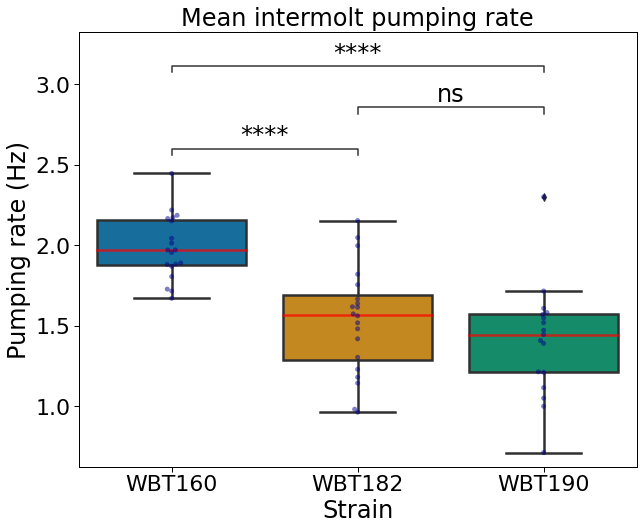

In [25]:
palette = sns.color_palette("colorblind")
strains = list(points_of_strains.keys())
order = strains
print(strains)
pairs = []

for i in range(len(strains)):
    for j in range(i+1, len(strains)):
        pairs.append((strains[i], strains[j]))
        
mean_intermolt_dataframe = mean_intermolt_dataframe.dropna(subset=['MeanIntermoltPumping'])[['Strain', 'MeanIntermoltPumping']]
mean_intermolt_dataframe = mean_intermolt_dataframe.astype({'MeanIntermoltPumping': np.float64})
x = 'Strain'
y = 'MeanIntermoltPumping'

# Plot with seaborn

with sns.plotting_context("paper", font_scale=2.5):
    plt.figure(figsize=(10, 8))
    ax = sns.boxplot(data=mean_intermolt_dataframe, x=x, y=y, palette=palette, linewidth=2.5, order=order, medianprops=dict(color="red", alpha=0.7))
    sns.swarmplot(data=mean_intermolt_dataframe, x=x, y=y, color="darkblue", order=order, ax=ax, alpha=0.5)

    annotator = Annotator(ax, pairs, data=mean_intermolt_dataframe, x=x, y=y, order=order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
    annotator.apply_and_annotate()

    # Set title and axis labels
    ax.set_title('Mean intermolt pumping rate')
    ax.set_xlabel('Strain')
    ax.set_ylabel('Pumping rate (Hz)')

    plt.savefig('./plots/mean_intermolt_pumping_rate.svg', dpi=300, bbox_inches='tight', facecolor='white')
    # Show the plot
    plt.show()

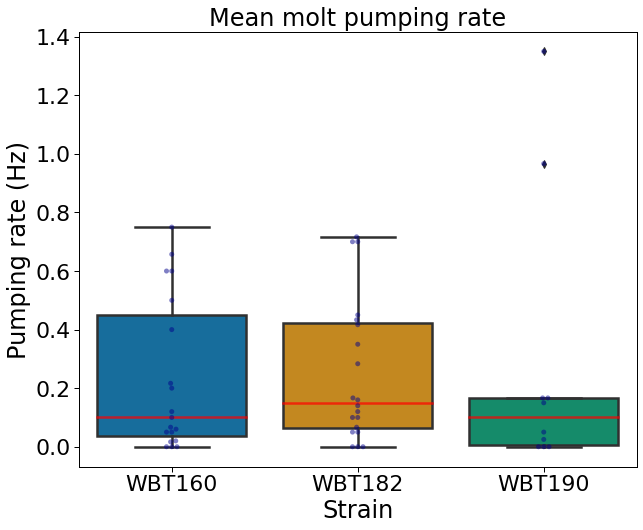

In [26]:
mean_molt_dataframe = mean_molt_dataframe.dropna(subset=['MeanMoltPumping'])[['Strain', 'MeanMoltPumping']]
mean_molt_dataframe = mean_molt_dataframe.astype({'MeanMoltPumping': np.float64})
x = 'Strain'
y = 'MeanMoltPumping'

# Plot with seaborn

with sns.plotting_context("paper", font_scale=2.5):
    plt.figure(figsize=(10, 8))
    ax = sns.boxplot(data=mean_molt_dataframe, x=x, y=y, palette=palette, linewidth=2.5, order=order, medianprops=dict(color="red", alpha=0.7))
    sns.swarmplot(data=mean_molt_dataframe, x=x, y=y, color="darkblue", order=order, ax=ax, alpha=0.5)

    # Set title and axis labels
    ax.set_title('Mean molt pumping rate')
    ax.set_xlabel('Strain')
    ax.set_ylabel('Pumping rate (Hz)')

    plt.savefig('./plots/mean_molt_pumping_rate.svg', dpi=300, bbox_inches='tight', facecolor='white')
    # Show the plot
    plt.show()

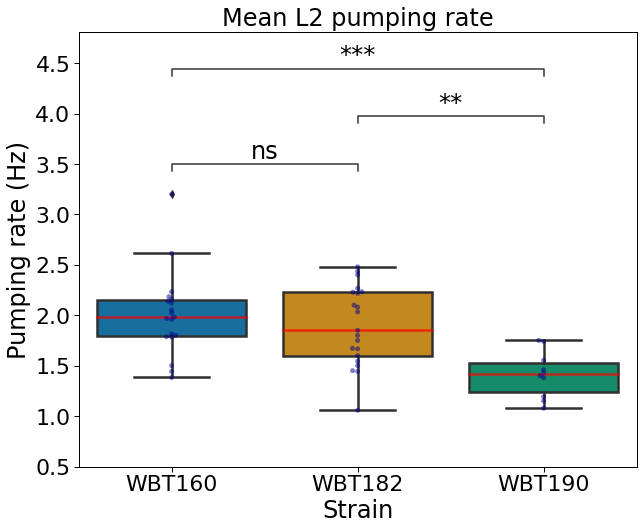

In [27]:
mean_dataframe = mean_dataframe.astype({'L2_mean': np.float64, 'L3_mean': np.float64, 'L4_mean': np.float64})

with sns.plotting_context("paper", font_scale=2.5):
    plt.figure(figsize=(10, 8))
    ax = sns.boxplot(data=mean_dataframe, x='Strain', y='L2_mean', palette=palette, linewidth=2.5, order=order, medianprops=dict(color="red", alpha=0.7))
    sns.swarmplot(data=mean_dataframe, x='Strain', y='L2_mean', color="darkblue", order=order, ax=ax, alpha=0.5)
    ax.set_ylim(0.5, 4.0)
    
    annotator = Annotator(ax, pairs, data=mean_dataframe,x='Strain', y='L2_mean', order=order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
    annotator.apply_and_annotate()

    # Set title and axis labels
    ax.set_title('Mean L2 pumping rate')
    ax.set_xlabel('Strain')
    ax.set_ylabel('Pumping rate (Hz)')

    plt.savefig('./plots/mean_L2_pumping_rate.svg', dpi=300, bbox_inches='tight', facecolor='white')
    # Show the plot
    plt.show()

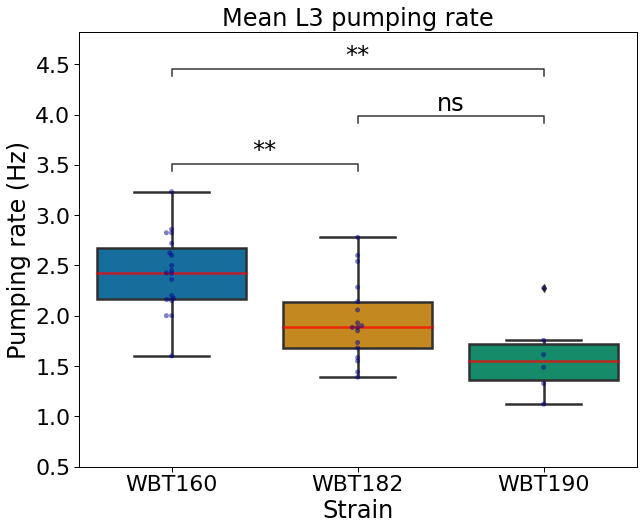

In [28]:
with sns.plotting_context("paper", font_scale=2.5):
    plt.figure(figsize=(10, 8))
    ax = sns.boxplot(data=mean_dataframe, x='Strain', y='L3_mean', palette=palette, linewidth=2.5, order=order, medianprops=dict(color="red", alpha=0.7))
    sns.swarmplot(data=mean_dataframe, x='Strain', y='L3_mean', color="darkblue", order=order, ax=ax, alpha=0.5)
    ax.set_ylim(0.5, 4.0)

    annotator = Annotator(ax, pairs, data=mean_dataframe,x='Strain', y='L3_mean', order=order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
    annotator.apply_and_annotate()

    # Set title and axis labels
    ax.set_title('Mean L3 pumping rate')
    ax.set_xlabel('Strain')
    ax.set_ylabel('Pumping rate (Hz)')
    

    plt.savefig('./plots/mean_L3_pumping_rate.svg', dpi=300, bbox_inches='tight', facecolor='white')
    # Show the plot
    plt.show()

c:\Users\sacha\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\sacha\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


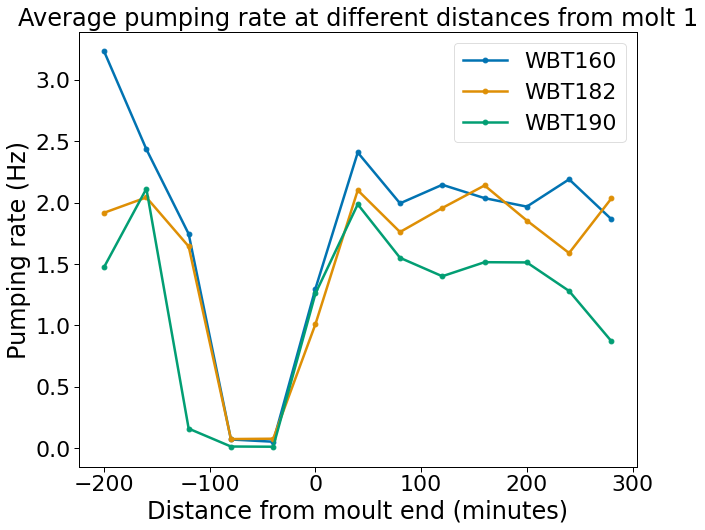

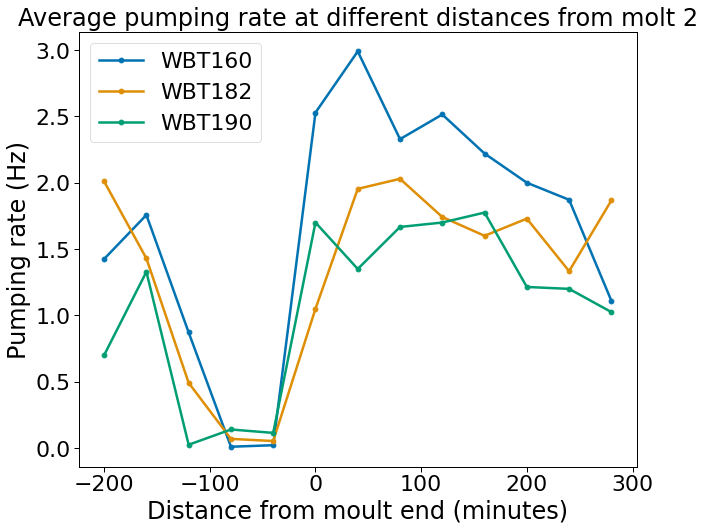

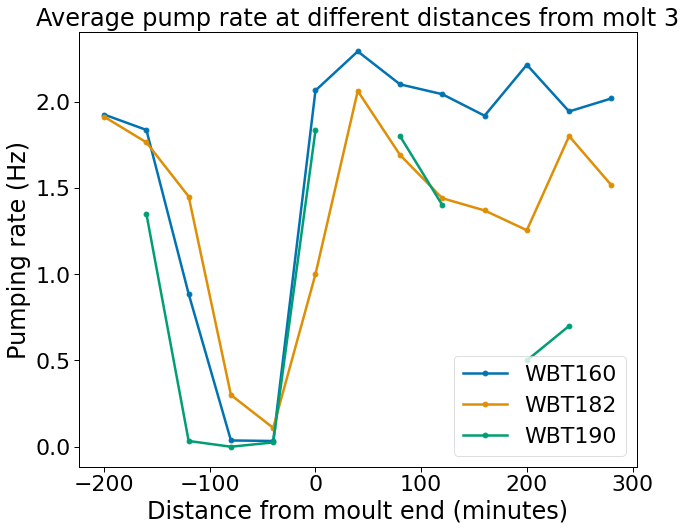

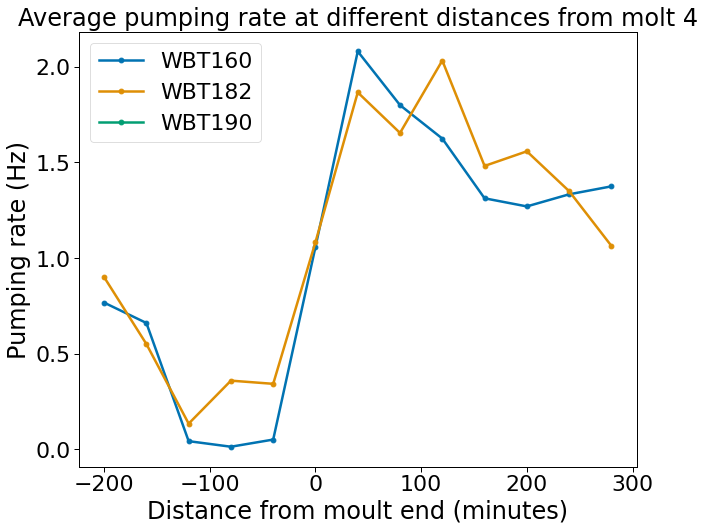

In [29]:
points_of_strains = {'WBT160' : (0, 20), 'WBT182' : (21, 41), 'WBT190' : (42, 58)}
distance_to_m1_pump_of_strains = {}
distance_to_m2_pump_of_strains = {}
distance_to_m3_pump_of_strains = {}
distance_to_m4_pump_of_strains = {}

def get_global_distance_from_moult(filemap, time_range = [-200, 320], points_to_exclude = [51, 52, 53, 54, 55, 56, 57]):
    global_distance_to_m1_pump = []
    global_distance_to_m2_pump = []
    global_distance_to_m3_pump = []
    global_distance_to_m4_pump = []

    for point in filemap['Point'].unique():
        
        data_of_point = filemap[filemap['Point'] == point]
        m1 = data_of_point['M1'].values[0]
        m2 = data_of_point['M2'].values[0]
        m3 = data_of_point['M3'].values[0]
        m4 = data_of_point['M4'].values[0]

        time_pump = data_of_point[['Time', 'PumpRate']].values

        distance_to_m1_pump = []
        distance_to_m2_pump = []
        distance_to_m3_pump = []
        distance_to_m4_pump = []

        if point in points_to_exclude:
            continue
        
        if np.isfinite(m1):
            for tp in time_pump:
                distance_to_m1 = (tp[0] - m1)*10
                if distance_to_m1 > time_range[0] and distance_to_m1 < time_range[1] and np.isfinite(tp[1]):
                    p = [(tp[0] - m1)*10, tp[1]]
                    distance_to_m1_pump.append(p)
        
        if np.isfinite(m2):
            for tp in time_pump:
                distance_to_m2 = (tp[0] - m2)*10
                if distance_to_m2 > time_range[0] and distance_to_m2 < time_range[1] and np.isfinite(tp[1]):
                    p = [(tp[0] - m2)*10, tp[1]]
                    distance_to_m2_pump.append(p)

        if np.isfinite(m3):
            for tp in time_pump:
                distance_to_m3 = (tp[0] - m3)*10
                if distance_to_m3 > time_range[0] and distance_to_m3 < time_range[1] and np.isfinite(tp[1]):
                    p = [(tp[0] - m3)*10, tp[1]]
                    distance_to_m3_pump.append(p)
        
        if np.isfinite(m4):
            for tp in time_pump:
                distance_to_m4 = (tp[0] - m4)*10
                if distance_to_m4 > time_range[0] and distance_to_m4 < time_range[1] and np.isfinite(tp[1]):
                    p = [(tp[0] - m4)*10, tp[1]]
                    distance_to_m4_pump.append(p)

        
        global_distance_to_m1_pump.extend(distance_to_m1_pump)
        global_distance_to_m2_pump.extend(distance_to_m2_pump)
        global_distance_to_m3_pump.extend(distance_to_m3_pump)
        global_distance_to_m4_pump.extend(distance_to_m4_pump)

    return global_distance_to_m1_pump, global_distance_to_m2_pump, global_distance_to_m3_pump, global_distance_to_m4_pump


for strain in points_of_strains.keys():
    start_point, end_point = points_of_strains[strain]
    filemap_of_strain = video_filemap[(video_filemap['Point'] >= start_point) & (video_filemap['Point'] <= end_point)]
    distance_to_m1_pump, distance_to_m2_pump, distance_to_m3_pump, distance_to_m4_pump  = get_global_distance_from_moult(filemap_of_strain)

    bins = [-200 + 40*i for i in range(14)]

    binned_data_m1 = [[] for i in range(13)]
    mean_binned_data_m1 = []

    binned_data_m2 = [[] for i in range(13)]
    mean_binned_data_m2 = []

    binned_data_m3 = [[] for i in range(13)]
    mean_binned_data_m3 = []

    binned_data_m4 = [[] for i in range(13)]
    mean_binned_data_m4 = []

    for p in distance_to_m1_pump:
        for i in range(len(bins)-1):
            if p[0] >= bins[i] and p[0] < bins[i+1]:
                binned_data_m1[i].append((p[1]))
    
    for b in binned_data_m1:
        mean_binned_data_m1.append(np.mean(b))

    for p in distance_to_m2_pump:
        for i in range(len(bins)-1):
            if p[0] >= bins[i] and p[0] < bins[i+1]:
                binned_data_m2[i].append((p[1]))
    
    for b in binned_data_m2:
        mean_binned_data_m2.append(np.mean(b))

    for p in distance_to_m3_pump:
        for i in range(len(bins)-1):
            if p[0] >= bins[i] and p[0] < bins[i+1]:
                binned_data_m3[i].append((p[1]))
    
    for b in binned_data_m3:
        mean_binned_data_m3.append(np.mean(b))

    for p in distance_to_m4_pump:
        for i in range(len(bins)-1):
            if p[0] >= bins[i] and p[0] < bins[i+1]:
                binned_data_m4[i].append((p[1]))

    for b in binned_data_m4:
        mean_binned_data_m4.append(np.mean(b))

    distance_to_m1_pump_of_strains[strain] = mean_binned_data_m1
    distance_to_m2_pump_of_strains[strain] = mean_binned_data_m2
    distance_to_m3_pump_of_strains[strain] = mean_binned_data_m3
    distance_to_m4_pump_of_strains[strain] = mean_binned_data_m4

with sns.plotting_context("paper", font_scale=2.5):
    plt.figure(figsize=(10, 8))
    for i, strains in enumerate(distance_to_m1_pump_of_strains.keys()):
        plt.plot(bins[:-1], distance_to_m1_pump_of_strains[strains], label=strains, marker='o', color=palette[i], linewidth=2.5)
    plt.legend()

    plt.title('Average pumping rate at different distances from molt 1')
    plt.xlabel('Distance from moult end (minutes)')
    plt.ylabel('Pumping rate (Hz)')
    plt.show()

    plt.figure(figsize=(10, 8))
    for i, strains in enumerate(distance_to_m2_pump_of_strains.keys()):
        plt.plot(bins[:-1], distance_to_m2_pump_of_strains[strains], label=strains, marker='o', color=palette[i], linewidth=2.5)
    plt.title('Average pumping rate at different distances from molt 2')
    plt.xlabel('Distance from moult end (minutes)')
    plt.ylabel('Pumping rate (Hz)')
    plt.legend()
    plt.savefig('./plots/pumping_rate_distance_molt2.svg', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    plt.figure(figsize=(10, 8))
    for i, strains in enumerate(distance_to_m3_pump_of_strains.keys()):
        plt.plot(bins[:-1], distance_to_m3_pump_of_strains[strains], label=strains, marker='o', color=palette[i], linewidth=2.5)
    plt.title('Average pump rate at different distances from molt 3')
    plt.xlabel('Distance from moult end (minutes)')
    plt.ylabel('Pumping rate (Hz)')
    plt.legend()
    plt.savefig('./plots/pumping_rate_distance_molt3.svg', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    plt.figure(figsize=(10, 8))
    for i, strains in enumerate(distance_to_m4_pump_of_strains.keys()):
        plt.plot(bins[:-1], distance_to_m4_pump_of_strains[strains], label=strains, marker='o', color=palette[i], linewidth=2.5)
    plt.title('Average pumping rate at different distances from molt 4')
    plt.xlabel('Distance from moult end (minutes)')
    plt.ylabel('Pumping rate (Hz)')
    plt.legend()
    plt.show()




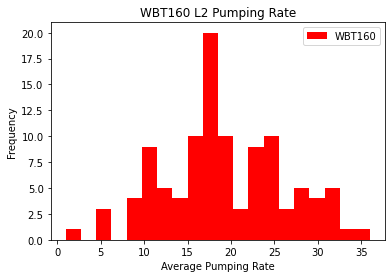

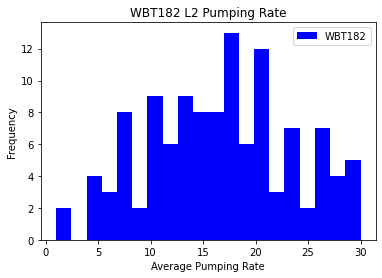

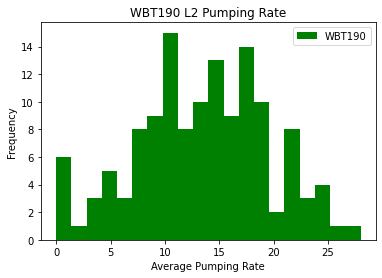

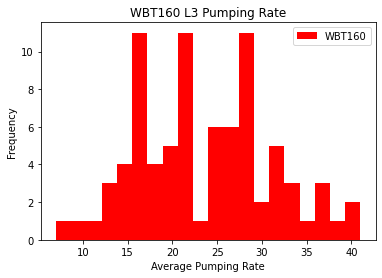

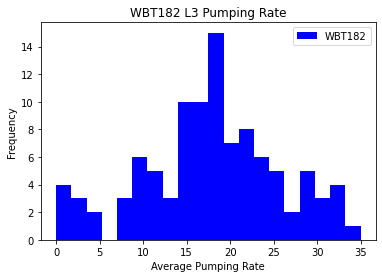

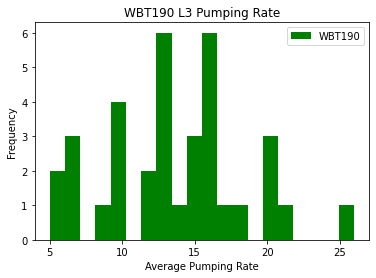

In [ ]:
histogram_l2_of_strains = {}
histogram_l3_of_strains = {}
histogram_l4_of_strains = {}

def get_intermolt_pumping(filemap, points_to_exclude = [51, 52, 53, 54, 55, 56, 57]):
    global_pumping_rate_l2 = []
    global_pumping_rate_l3 = []
    global_pumping_rate_l4 = []
    for point in filemap['Point'].unique():
        data_of_point = filemap[filemap['Point'] == point]
        if point in points_to_exclude:
            continue

        m1 = data_of_point['M1'].values[0]
        m2 = data_of_point['M2'].values[0]
        m3 = data_of_point['M3'].values[0]
        m4 = data_of_point['M4'].values[0]

        if np.isfinite(m1) and np.isfinite(m2):
            time_range = (m1+2, m2-14)
            pumping_rate_l2 = data_of_point[data_of_point['Time'] >= time_range[0]]
            pumping_rate_l2 = pumping_rate_l2[pumping_rate_l2['Time'] <= time_range[1]]['PumpCount'].dropna().tolist()
            global_pumping_rate_l2.extend(pumping_rate_l2)
        if np.isfinite(m2) and np.isfinite(m3):
            time_range = (m2+2, m3-14)
            pumping_rate_l3 = data_of_point[data_of_point['Time'] >= time_range[0]]
            pumping_rate_l3 = pumping_rate_l3[pumping_rate_l3['Time'] <= time_range[1]]['PumpCount'].dropna().tolist()
            global_pumping_rate_l3.extend(pumping_rate_l3)
        if np.isfinite(m3) and np.isfinite(m4):
            time_range = (m3+2, m4-14)
            pumping_rate_l4 = data_of_point[data_of_point['Time'] >= time_range[0]]
            pumping_rate_l4 = pumping_rate_l4[pumping_rate_l4['Time'] <= time_range[1]]['PumpCount'].dropna().tolist()
            global_pumping_rate_l4.extend(pumping_rate_l4)
        
        
    return global_pumping_rate_l2, global_pumping_rate_l3, global_pumping_rate_l4

for strain in points_of_strains.keys():
    start_point, end_point = points_of_strains[strain]
    filemap_of_strain = video_filemap[(video_filemap['Point'] >= start_point) & (video_filemap['Point'] <= end_point)]
    pumping_rate_l2, pumping_rate_l3, pumping_rate_l4 = get_intermolt_pumping(filemap_of_strain)
    histogram_l2_of_strains[strain] = pumping_rate_l2
    histogram_l3_of_strains[strain] = pumping_rate_l3
    histogram_l4_of_strains[strain] = pumping_rate_l4

colors = {'WBT160' : 'red', 'WBT182' : 'blue', 'WBT190' : 'green'}
for strain in histogram_l2_of_strains.keys():
    plt.hist(histogram_l2_of_strains[strain], bins=20, alpha=1, label=strain, color=colors[strain])
    plt.legend(loc='upper right')
    plt.title(f'{strain} L2 Pumping Rate')
    plt.xlabel('Average Pumping Rate')
    plt.ylabel('Frequency')
    plt.show()

for strain in histogram_l3_of_strains.keys():
    plt.hist(histogram_l3_of_strains[strain], bins=20, alpha=1, label=strain, color=colors[strain])
    plt.legend(loc='upper right')
    plt.title(f'{strain} L3 Pumping Rate')
    plt.xlabel('Average Pumping Rate')
    plt.ylabel('Frequency')
    plt.show()

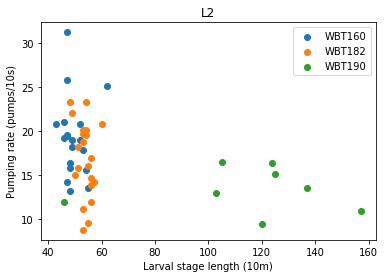

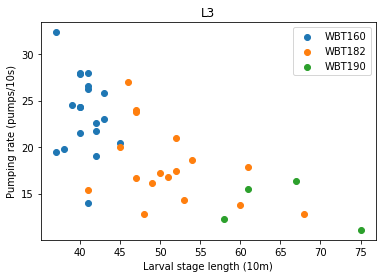

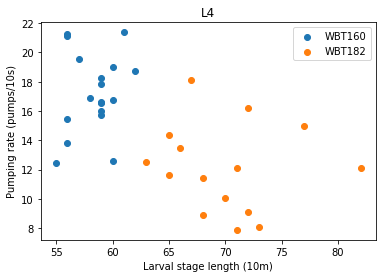

In [ ]:
pumping_per_larval_stage_length_l2_of_strains = {}
pumping_per_larval_stage_length_l3_of_strains = {}
pumping_per_larval_stage_length_l4_of_strains = {}

def get_mean_pumping_per_larval_stage_length(filemap, points_to_exclude = [51, 52, 53, 54, 55, 56, 57]):
    pumping_per_larval_stage_length_l2 = []
    pumping_per_larval_stage_length_l3 = []
    pumping_per_larval_stage_length_l4 = []

    for point in filemap['Point'].unique():
        data_of_point = filemap[filemap['Point'] == point]
        m1 = data_of_point['M1'].values[0]
        m2 = data_of_point['M2'].values[0]
        m3 = data_of_point['M3'].values[0]
        m4 = data_of_point['M4'].values[0]

        if np.isfinite(m1) and (not point in points_to_exclude):
            moulting_time = np.arange(0, m1).tolist()
            if np.isfinite(m2):
                intermolt = (m1+2, m2-14)
                pumping_rate_l2 = data_of_point[(data_of_point['Time']>= intermolt[0]) & (data_of_point['Time'] <= intermolt[1])]['PumpCount'].dropna().mean()
                pumping_per_larval_stage_length_l2.append((m2-m1, pumping_rate_l2))
            if np.isfinite(m3) and np.isfinite(m2):
                intermolt = (m2+2, m3-14)
                pumping_rate_l3 = data_of_point[(data_of_point['Time']>= intermolt[0]) & (data_of_point['Time'] <= intermolt[1])]['PumpCount'].dropna().mean()
                pumping_per_larval_stage_length_l3.append((m3-m2, pumping_rate_l3))
            if np.isfinite(m4) and np.isfinite(m3):
                intermolt = (m3+2, m4-14)
                pumping_rate_l4 = data_of_point[(data_of_point['Time']>= intermolt[0]) & (data_of_point['Time'] <= intermolt[1])]['PumpCount'].dropna().mean()
                pumping_per_larval_stage_length_l4.append((m4-m3, pumping_rate_l4))
            
            

    return pumping_per_larval_stage_length_l2, pumping_per_larval_stage_length_l3, pumping_per_larval_stage_length_l4


for strain in points_of_strains.keys():
    start_point, end_point = points_of_strains[strain]
    filemap_of_strain = video_filemap[(video_filemap['Point'] >= start_point) & (video_filemap['Point'] <= end_point)]
    pumping_per_larval_stage_length_l2, pumping_per_larval_stage_length_l3, pumping_per_larval_stage_length_l4 = get_mean_pumping_per_larval_stage_length(filemap_of_strain)
    
    pumping_per_larval_stage_length_l2_of_strains[strain] = pumping_per_larval_stage_length_l2
    pumping_per_larval_stage_length_l3_of_strains[strain] = pumping_per_larval_stage_length_l3
    pumping_per_larval_stage_length_l4_of_strains[strain] = pumping_per_larval_stage_length_l4

# Plotting

for strain in pumping_per_larval_stage_length_l2_of_strains.keys():
    plt.scatter(*zip(*pumping_per_larval_stage_length_l2_of_strains[strain]), label = strain)
plt.legend()
plt.title('L2')
plt.xlabel('Larval stage length (10m)')
plt.ylabel('Pumping rate (pumps/10s)')

plt.show()

for strain in pumping_per_larval_stage_length_l3_of_strains.keys():
    plt.scatter(*zip(*pumping_per_larval_stage_length_l3_of_strains[strain]), label = strain)
plt.legend()
plt.title('L3')
plt.xlabel('Larval stage length (10m)')
plt.ylabel('Pumping rate (pumps/10s)')
plt.show()

for strain in pumping_per_larval_stage_length_l4_of_strains.keys():
    if strain == 'WBT190':
        continue
    plt.scatter(*zip(*pumping_per_larval_stage_length_l4_of_strains[strain]), label = strain)
plt.legend()
plt.title('L4')
plt.xlabel('Larval stage length (10m)')
plt.ylabel('Pumping rate (pumps/10s)')
plt.show()


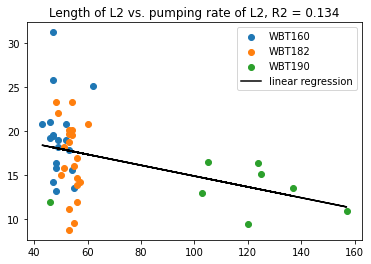

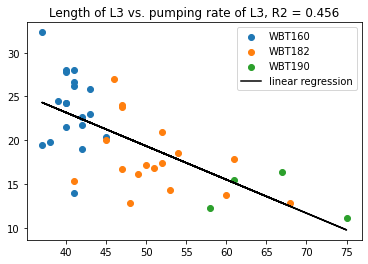

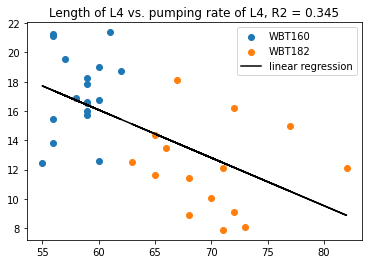

In [ ]:
from sklearn.linear_model import LinearRegression

global_pumping_per_larval_stage_length_l2 = [item for sublist in pumping_per_larval_stage_length_l2_of_strains.values() for item in sublist]
global_pumping_per_larval_stage_length_l3 = [item for sublist in pumping_per_larval_stage_length_l3_of_strains.values() for item in sublist]
global_pumping_per_larval_stage_length_l4 = [item for sublist in pumping_per_larval_stage_length_l4_of_strains.values() for item in sublist]

# fit linear regression model

# L2
x = np.array([item[0] for item in global_pumping_per_larval_stage_length_l2]).reshape((-1, 1))
y = np.array([item[1] for item in global_pumping_per_larval_stage_length_l2])
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)

# plot linear regression

plt.title(f'Length of L2 vs. pumping rate of L2, R2 = {r_sq:.3f}')
for strain in pumping_per_larval_stage_length_l2_of_strains.keys():
    plt.scatter(*zip(*pumping_per_larval_stage_length_l2_of_strains[strain]), label = strain)
plt.plot(x, model.predict(x), label = 'linear regression', color = 'black')
plt.legend()
plt.show()

# L3
x = np.array([item[0] for item in global_pumping_per_larval_stage_length_l3]).reshape((-1, 1))
y = np.array([item[1] for item in global_pumping_per_larval_stage_length_l3])
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)

# plot linear regression

plt.title(f'Length of L3 vs. pumping rate of L3, R2 = {r_sq:.3f}')
for strain in pumping_per_larval_stage_length_l3_of_strains.keys():
    plt.scatter(*zip(*pumping_per_larval_stage_length_l3_of_strains[strain]), label = strain)
plt.plot(x, model.predict(x), label = 'linear regression', color = 'black')
plt.legend()
plt.show()

# L4
x = np.array([item[0] for item in global_pumping_per_larval_stage_length_l4]).reshape((-1, 1))
y = np.array([item[1] for item in global_pumping_per_larval_stage_length_l4])
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)

# plot linear regression

plt.title(f'Length of L4 vs. pumping rate of L4, R2 = {r_sq:.3f}')
for strain in pumping_per_larval_stage_length_l4_of_strains.keys():
    if strain == 'WBT190':
        continue
    plt.scatter(*zip(*pumping_per_larval_stage_length_l4_of_strains[strain]), label = strain)
plt.plot(x, model.predict(x), label = 'linear regression', color = 'black')
plt.legend()
plt.show()



C:\Users\sacha\AppData\Local\Temp\ipykernel_16956\2047878937.py:8: RuntimeWarning: divide by zero encountered in log10
  log_volume_of_point = np.log10(analysis_filemap[analysis_filemap['Point'] == point]['Volume'].values)


Text(0.5, 1.0, 'L4, R^2 = 0.219')

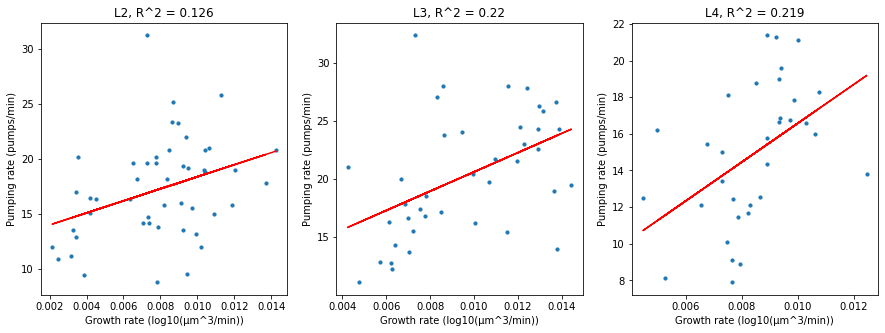

In [ ]:
def get_mean_pumping_per_growth_rate(video_filemap, analysis_filemap, points_to_exclude = [51, 52, 53, 54, 55, 56, 57]):
    pumping_per_growth_rate_l2 = []
    pumping_per_growth_rate_l3 = []
    pumping_per_growth_rate_l4 = []

    for point in video_filemap['Point'].unique():
        data_of_point = video_filemap[video_filemap['Point'] == point]
        log_volume_of_point = np.log10(analysis_filemap[analysis_filemap['Point'] == point]['Volume'].values)
        log_volume_of_point[np.isinf(log_volume_of_point)] = np.nan
        log_volume_of_point = medfilt(log_volume_of_point, 5)

        worm_types = analysis_filemap[analysis_filemap['Point'] == point]['WormType'].values
        m1 = data_of_point['M1'].values[0]
        m2 = data_of_point['M2'].values[0]
        m3 = data_of_point['M3'].values[0]
        m4 = data_of_point['M4'].values[0]

        if np.isfinite(m1) and (not point in points_to_exclude):
            if np.isfinite(m2):
                intermolt = (m1+2, m2-14)
                pumping_rate_l2 = data_of_point[(data_of_point['Time']>= intermolt[0]) & (data_of_point['Time'] <= intermolt[1])]['PumpCount'].dropna().mean()

                volume_start = log_volume_of_point[int(intermolt[0])]
                volume_end = log_volume_of_point[int(intermolt[1])]

                while worm_types[int(intermolt[0])] == 'error':
                    intermolt = (intermolt[0]+1, intermolt[1])
                    volume_start = log_volume_of_point[int(intermolt[0])]

                while worm_types[int(intermolt[1])] == 'error':
                    intermolt = (intermolt[0], intermolt[1]-1)
                    volume_end = log_volume_of_point[int(intermolt[1])]

                growth_rate = (volume_end - volume_start)/(intermolt[1] - intermolt[0])
                pumping_per_growth_rate_l2.append((growth_rate, pumping_rate_l2))
            if np.isfinite(m3) and np.isfinite(m2):
                intermolt = (m2+2, m3-14)
                pumping_rate_l3 = data_of_point[(data_of_point['Time']>= intermolt[0]) & (data_of_point['Time'] <= intermolt[1])]['PumpCount'].dropna().mean()
                
                volume_start = log_volume_of_point[int(intermolt[0])]
                volume_end = log_volume_of_point[int(intermolt[1])]

                while worm_types[int(intermolt[0])] == 'error':
                    intermolt = (intermolt[0]+1, intermolt[1])
                    volume_start = log_volume_of_point[int(intermolt[0])]

                while worm_types[int(intermolt[1])] == 'error':
                    intermolt = (intermolt[0], intermolt[1]-1)
                    volume_end = log_volume_of_point[int(intermolt[1])]

                growth_rate = (volume_end - volume_start)/(intermolt[1] - intermolt[0])

                pumping_per_growth_rate_l3.append((growth_rate, pumping_rate_l3))
            if np.isfinite(m4) and np.isfinite(m3):
                intermolt = (m3+2, m4-14)
                pumping_rate_l4 = data_of_point[(data_of_point['Time']>= intermolt[0]) & (data_of_point['Time'] <= intermolt[1])]['PumpCount'].dropna().mean()
                
                volume_start = log_volume_of_point[int(intermolt[0])]
                volume_end = log_volume_of_point[int(intermolt[1])]

                while worm_types[int(intermolt[0])] == 'error':
                    intermolt = (intermolt[0]+1, intermolt[1])
                    volume_start = log_volume_of_point[int(intermolt[0])]

                while worm_types[int(intermolt[1])] == 'error':
                    intermolt = (intermolt[0], intermolt[1]-1)
                    volume_end = log_volume_of_point[int(intermolt[1])]
                    
                growth_rate = (volume_end - volume_start)/(intermolt[1] - intermolt[0])
                
                pumping_per_growth_rate_l4.append((growth_rate, pumping_rate_l4))
        
    return pumping_per_growth_rate_l2, pumping_per_growth_rate_l3, pumping_per_growth_rate_l4

pumping_per_growth_rate_l2, pumping_per_growth_rate_l3, pumping_per_growth_rate_l4 = get_mean_pumping_per_growth_rate(video_filemap, analysis_filemap)

x_l2 = np.array([item[0] for item in pumping_per_growth_rate_l2]).reshape((-1, 1))
y_l2 = np.array([item[1] for item in pumping_per_growth_rate_l2])
model_l2 = LinearRegression().fit(x_l2, y_l2)
r_sq_l2 = model_l2.score(x_l2, y_l2)

x_l3 = np.array([item[0] for item in pumping_per_growth_rate_l3]).reshape((-1, 1))
y_l3 = np.array([item[1] for item in pumping_per_growth_rate_l3])
model_l3 = LinearRegression().fit(x_l3, y_l3)
r_sq_l3 = model_l3.score(x_l3, y_l3)

x_l4 = np.array([item[0] for item in pumping_per_growth_rate_l4]).reshape((-1, 1))
y_l4 = np.array([item[1] for item in pumping_per_growth_rate_l4])
model_l4 = LinearRegression().fit(x_l4, y_l4)
r_sq_l4 = model_l4.score(x_l4, y_l4)

# Plot
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].scatter(*zip(*pumping_per_growth_rate_l2), s = 10)
ax[0].plot(x_l2, model_l2.predict(x_l2), color = 'red')
ax[0].set_xlabel('Growth rate (log10(µm^3/min))')
ax[0].set_ylabel('Pumping rate (pumps/min)')
ax[0].set_title('L2, R^2 = ' + str(round(r_sq_l2, 3)))

ax[1].scatter(*zip(*pumping_per_growth_rate_l3), s = 10)
ax[1].plot(x_l3, model_l3.predict(x_l3), color = 'red')
ax[1].set_xlabel('Growth rate (log10(µm^3/min))')
ax[1].set_ylabel('Pumping rate (pumps/min)')
ax[1].set_title('L3, R^2 = ' + str(round(r_sq_l3, 3)))

ax[2].scatter(*zip(*pumping_per_growth_rate_l4), s = 10)
ax[2].plot(x_l4, model_l4.predict(x_l4), color = 'red')
ax[2].set_xlabel('Growth rate (log10(µm^3/min))')
ax[2].set_ylabel('Pumping rate (pumps/min)')
ax[2].set_title('L4, R^2 = ' + str(round(r_sq_l4, 3)))

